# Create Mock Events and Test Model Initialization

This notebook tests the SIDIS framework, particularly the flexible model implementation (`fNPconfig_base_flexible.yaml`).

Objectives:
1. Generate mock data in pytorch format
2. Generate cross sections from mock data, using the simple base model.
    - save those cross sections into outs/ both in yaml and pytorch format. 
    - IMPORTANT NOTE: The notebook runs a minimal implementation for the cross section generation, NOT `run_cross_section_from_mock.py`
3. Study the bT-shapes of the PDF and FF NP
4. Check that the model can be initialized correctly



In [1]:
# Setup and imports
import sys
import pathlib
import torch
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

# Add parent directory to path so sidis can be imported as a package
parent_dir = pathlib.Path().resolve().parent.parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

from sidis.model import TrainableModel
from sidis.utilities.colors import tcolors

# Set default tensor dtype to float64 for high precision
torch.set_default_dtype(torch.float64)

print(f"{tcolors.GREEN}Setup complete!{tcolors.ENDC}")
print(f"PyTorch version: {torch.__version__}")
print(f"Default dtype: {torch.get_default_dtype()}")

Setup complete!
PyTorch version: 2.6.0
Default dtype: torch.float64


In [2]:
# Folder to save the plots
plots_dir = pathlib.Path().resolve() / "plots"
plots_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Input data folder
data_dir = pathlib.Path().resolve() / "inputs"
data_dir.mkdir(parents=True, exist_ok=True)


## Section 1: Mock Event Generation

Generate synthetic **unpolarized** SIDIS event data in the format expected by the model: each event is a row with **4 columns** `[x, PhT, Q, z]`:

- **x**: Bjorken x (momentum fraction), uniform in [0.01, 0.9]
- **PhT**: transverse momentum of the hadron (GeV), uniform in [0.1, 5.0] with PhT/(z·Q) < 0.2 per event
- **Q**: hard scale (GeV), uniform in [2.0, 100.0]
- **z**: fragmentation fraction, uniform in [0.2, 0.8]

We generate different sizes (100, 1000 events) with a fixed seed for reproducibility. 
The file **`mock_events_1000.dat`** saved below contains the **1000-event** dataset; this is the file used by `main_with_minimization.py` and `run_cross_section_from_mock.py` when run with the default events file.

In [4]:
def generate_mock_events(n_events=100, seed=42):
    """
    Generate synthetic unpolarized SIDIS event data.

    Each event has 4 columns: [x, PhT, Q, z]. Values are drawn uniformly
    in realistic kinematic ranges (see below). PhT respects the boundary
    PhT/(z*Q) < 0.2 for each event.

    Parameters:
    -----------
    n_events : int
        Number of events to generate
    seed : int
        Random seed for reproducibility

    Returns:
    --------
    torch.Tensor
        Event tensor of shape (n_events, 4)
    """
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Realistic kinematic ranges
    x_min, x_max = 0.001, 0.9     # Bjorken x
    PhT_min, PhT_max = 0.1, 5.0   # Transverse momentum (GeV)
    Q_min, Q_max = 2.0, 1000.0    # Hard scale (GeV)
    z_min, z_max = 0.2, 0.8       # Fragmentation fraction

    # Generate x, Q, z in a naive way, uniformly in their ranges
    # x sampled log-uniform in [x_min, x_max]
    x = np.exp(np.random.uniform(np.log(x_min), np.log(x_max), n_events))
    Q = np.random.uniform(Q_min, Q_max, n_events)
    z = np.random.uniform(z_min, z_max, n_events)

    # PhT must satisfy PhT/(z*Q) < 0.2 for each event, i.e. PhT < 0.2 * z * Q
    # This is to be sure to stay in the TMD region.
    # PhT_upper is a numpy array (shape: [n_events]), giving the upper bound on PhT for each event.
    # For each event, PhT_upper[i] = min(PhT_max, 0.2 * z[i] * Q[i]).
    # This ensures the sampled PhT never exceeds the physical TMD bound PhT/(z*Q)<0.2, but never above PhT_max.
    PhT_upper = np.minimum(PhT_max, 0.2 * z * Q)
    
    # Resample Q, z for events where upper bound is below PhT_min
    mask = PhT_upper < PhT_min
    while np.any(mask):
        n_bad = np.sum(mask)
        Q[mask] = np.random.uniform(Q_min, Q_max, n_bad)
        z[mask] = np.random.uniform(z_min, z_max, n_bad)
        PhT_upper[mask] = np.minimum(PhT_max, 0.2 * z[mask] * Q[mask])
        mask = PhT_upper < PhT_min
    PhT = np.random.uniform(PhT_min, PhT_upper, n_events)

    events = torch.tensor(np.column_stack([x, PhT, Q, z]), dtype=torch.float64)
    return events


# Generate unpolarized datasets of different sizes
print(f"{tcolors.BOLDWHITE}Generating mock event data (unpolarized)...{tcolors.ENDC}")

mock_data_100 = generate_mock_events(n_events=100, seed=42)
mock_data_1000 = generate_mock_events(n_events=1000, seed=42)

print("Generated datasets:")
print(f"  - 100 events:  shape {mock_data_100.shape}  {tcolors.GREEN}← this is saved to mock_events_100.dat {tcolors.ENDC}")
print(f"  - 1000 events: shape {mock_data_1000.shape} {tcolors.GREEN}← this is saved to mock_events_1000.dat {tcolors.ENDC}")

# Save the 100-event set in mock_events.dat; 
# this is what main_with_minimization.py and run_cross_section_from_mock.py use by default.
# Saving also the 1000-event set in mock_events_1000.dat for reference.
output_file_100 = pathlib.Path().resolve().joinpath("inputs", "mock_events_100.dat")
output_file_1000 = pathlib.Path().resolve().joinpath("inputs", "mock_events_1000.dat")
torch.save(mock_data_100, output_file_100)
torch.save(mock_data_1000, output_file_1000)
print(f"\n{tcolors.GREEN}Saved mock data to: {output_file_100}{tcolors.ENDC} (100 events)")
print(f"{tcolors.GREEN}Saved mock data to: {output_file_1000}{tcolors.ENDC} (1000 events)")

# Display sample events
print(f"\n{tcolors.BOLDWHITE}Sample events (first 5):{tcolors.ENDC}")
print(mock_data_100[:5])

Generating mock event data (unpolarized)...
Generated datasets:
  - 100 events:  shape torch.Size([100, 4])  ← this is saved to mock_events_100.dat 
  - 1000 events: shape torch.Size([1000, 4]) ← this is saved to mock_events_1000.dat 

Saved mock data to: /Users/cbissolotti/anl/projects/tmd/sidis/tests/inputs/mock_events_100.dat (100 events)
Saved mock data to: /Users/cbissolotti/anl/projects/tmd/sidis/tests/inputs/mock_events_1000.dat (1000 events)

Sample events (first 5):
tensor([[1.2779e-02, 2.9667e-01, 3.3366e+01, 5.8522e-01],
        [6.4364e-01, 2.7036e+00, 6.3714e+02, 2.5048e-01],
        [1.4537e-01, 2.7491e+00, 3.1573e+02, 2.9698e-01],
        [5.8692e-02, 3.2234e+00, 5.0955e+02, 7.3913e-01],
        [2.8901e-03, 3.6578e+00, 9.0775e+02, 5.6386e-01]])


### Plot mock data

Visualize the distributions of the generated kinematic variables (x, PhT, Q, z). Plots below use the **1000-event** sample for smoother histograms; `mock_events.dat` contains 100 events.

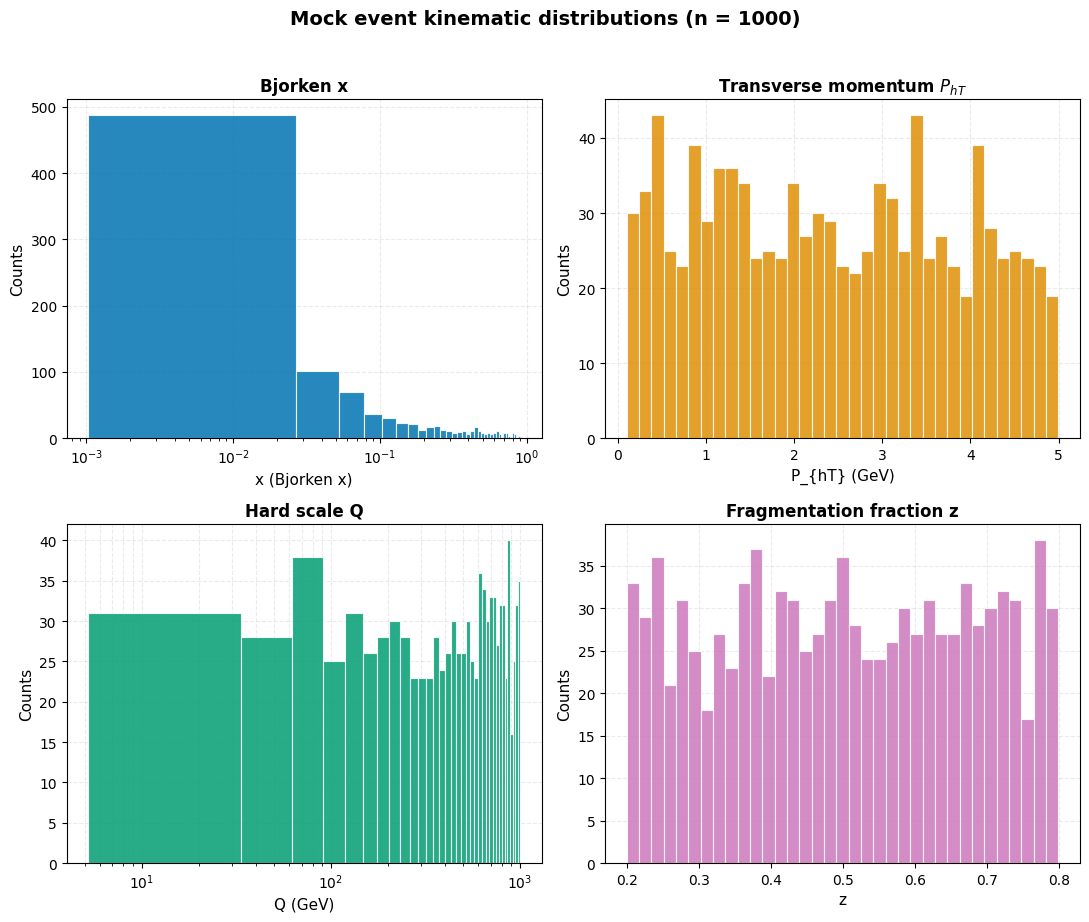

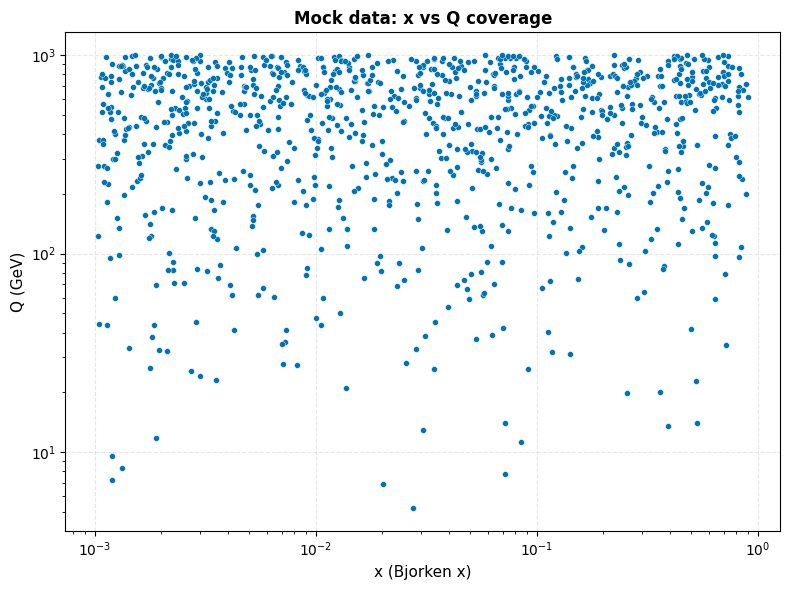

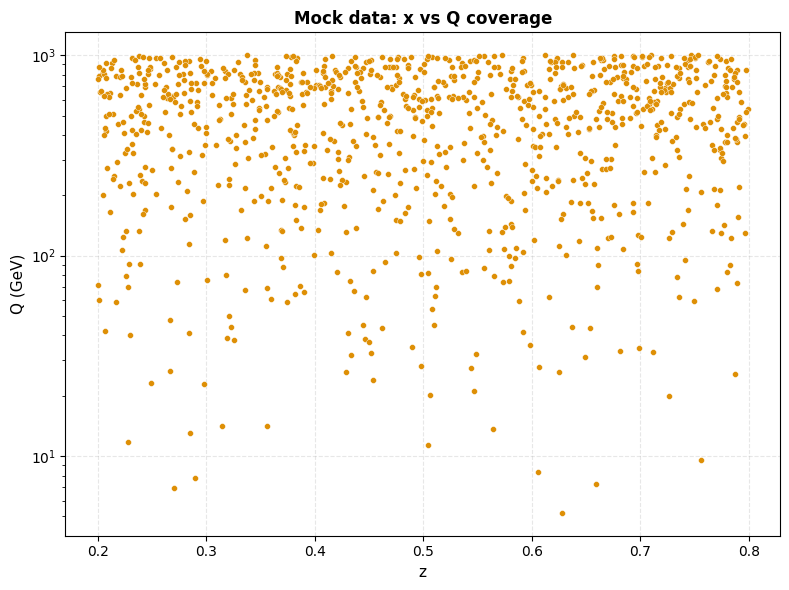

In [5]:
# Plot mock data distributions
# data = mock_data_100
data = mock_data_1000

# Kinematic variables
x_plot = data[:, 0].numpy()
PhT_plot = data[:, 1].numpy()
Q_plot = data[:, 2].numpy()
z_plot = data[:, 3].numpy()

# Distinct colors per variable for clarity (colorblind-friendly)
colors = ["#0173b2", "#de8f05", "#029e73", "#cc78bc"]  # blue, orange, green, purple
labels = ["x (Bjorken x)", "P_{hT} (GeV)", "Q (GeV)", "z"]

fig, axes = plt.subplots(2, 2, figsize=(11, 9), facecolor="white")

axes[0, 0].hist(x_plot, bins=35, color=colors[0], edgecolor="white", linewidth=0.8, alpha=0.85)
axes[0, 0].set_xlabel(labels[0], fontsize=11)
axes[0, 0].set_ylabel("Counts", fontsize=11)
axes[0, 0].set_title("Bjorken x", fontsize=12, fontweight="bold")
axes[0, 0].set_xscale("log")
axes[0, 0].grid(True, alpha=0.25, linestyle="--")
axes[0, 0].set_axisbelow(True)

axes[0, 1].hist(PhT_plot, bins=35, color=colors[1], edgecolor="white", linewidth=0.8, alpha=0.85)
axes[0, 1].set_xlabel(labels[1], fontsize=11)
axes[0, 1].set_ylabel("Counts", fontsize=11)
axes[0, 1].set_title(r"Transverse momentum $P_{hT}$", fontsize=12, fontweight="bold")
axes[0, 1].grid(True, alpha=0.25, linestyle="--")
axes[0, 1].set_axisbelow(True)

axes[1, 0].hist(Q_plot, bins=35, color=colors[2], edgecolor="white", linewidth=0.8, alpha=0.85)
axes[1, 0].set_xlabel(labels[2], fontsize=11)
axes[1, 0].set_ylabel("Counts", fontsize=11)
axes[1, 0].set_title("Hard scale Q", fontsize=12, fontweight="bold")
axes[1, 0].set_xscale("log")
axes[1, 0].grid(True, alpha=0.25, linestyle="--", which="both")
axes[1, 0].set_axisbelow(True)

axes[1, 1].hist(z_plot, bins=35, color=colors[3], edgecolor="white", linewidth=0.8, alpha=0.85)
axes[1, 1].set_xlabel(labels[3], fontsize=11)
axes[1, 1].set_ylabel("Counts", fontsize=11)
axes[1, 1].set_title("Fragmentation fraction z", fontsize=12, fontweight="bold")
axes[1, 1].grid(True, alpha=0.25, linestyle="--")
axes[1, 1].set_axisbelow(True)

fig.suptitle("Mock event kinematic distributions (n = 1000)", fontsize=14, fontweight="bold", y=1.02)
plt.savefig(plots_dir / "mock_events_kinematics_1000.pdf")
plt.tight_layout()
plt.show()

# 2D scatter: x vs Q (SIDIS kinematic coverage)
fig2, ax2 = plt.subplots(figsize=(8, 6), facecolor="white")
ax2.scatter(x_plot, Q_plot, s=18, c=colors[0], edgecolors="white", linewidths=0.3)
ax2.set_xlabel("x (Bjorken x)", fontsize=11)
ax2.set_ylabel("Q (GeV)", fontsize=11)
ax2.set_title("Mock data: x vs Q coverage", fontsize=12, fontweight="bold")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid(True, alpha=0.3, linestyle="--")
ax2.set_axisbelow(True)
plt.tight_layout()
plt.show()

# 2D scatter: z vs Q (SIDIS kinematic coverage)
fig2, ax2 = plt.subplots(figsize=(8, 6), facecolor="white")
ax2.scatter(z_plot, Q_plot, s=18, c=colors[1], edgecolors="white", linewidths=0.3)
ax2.set_xlabel(labels[3], fontsize=11)
ax2.set_ylabel("Q (GeV)", fontsize=11)
ax2.set_title("Mock data: x vs Q coverage", fontsize=12, fontweight="bold")
ax2.set_yscale("log")
ax2.grid(True, alpha=0.3, linestyle="--")
ax2.set_axisbelow(True)
plt.tight_layout()
plt.show()

## Section 2: Study fNP parametrizations

### simple exponential parametrization

In [6]:
from IPython.display import display, Math

# --- LaTeX strings (exact functional forms)
latex_pdf = r"\tilde f_{1,\mathrm{NP}}^{\,q}(x,b_T)=\exp\!\left[-\frac{b_T^2}{4}\,\lambda_f^2\,x^{\alpha}(1-x)^2\right]"
latex_ff  = r"\tilde D_{1,\mathrm{NP}}^{\,q}(z,b_T)=\exp\!\left[-\frac{b_T^2}{4}\,\lambda_D^2\,z^{\beta}(1-z)^2\right]"
latex_cs  = r"S(Q,b_T;Q_0)=\exp\!\left[-\frac{b_T^2}{4}\,g_K\,\ln\!\left(\frac{Q^2}{Q_0^2}\right)\right]"

# --- Display as rendered LaTeX in the notebook
display(Math(latex_pdf))
display(Math(latex_ff))
display(Math(latex_cs))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

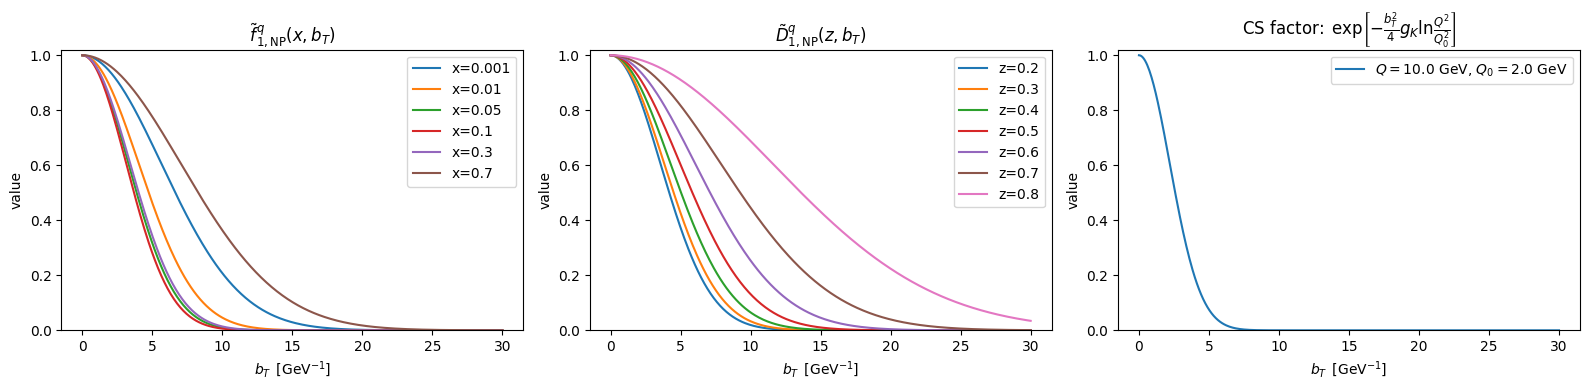

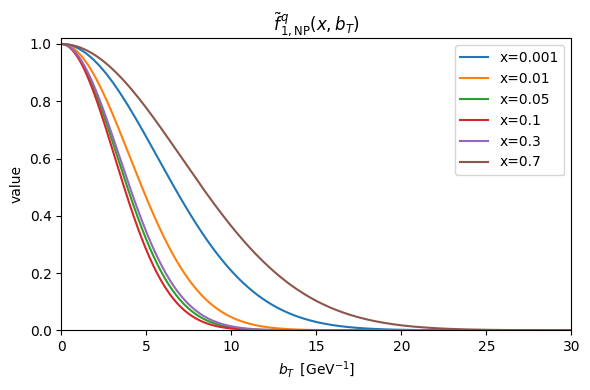

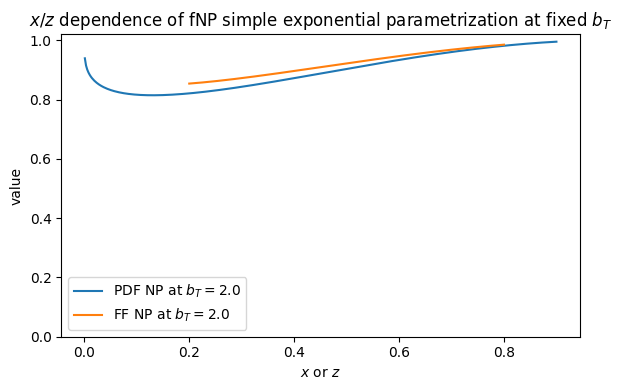

In [16]:

import numpy as np
import matplotlib.pyplot as plt

# --- Parameter choices (edit freely). 
# These are the initial choices for the parameters of the u quark, PDFs and FFs.
lam2_f1 = 0.5   # GeV^2  (lambda_f^2)
alpha   = 0.3
lam2_D1 = 0.4   # GeV^2  (lambda_D^2)
beta    = 0.3
gK      = 0.1284   # GeV^2  (the coefficient in exp[- b_T^2/4 * gK * ln(Q^2/Q0^2)]
Q0      = 2.0      # GeV
Q       = 10.0     # GeV

# --- Grids
x = np.linspace(1e-3, 0.9, 400)
z = np.linspace(0.2, 0.8, 400)
b = np.linspace(0.0, 30.0, 400)  # b_T in GeV^-1

# --- Functional forms (as in your LaTeX)
def fNP_pdf(x, bT, lam2_f1=lam2_f1, alpha=alpha):
    return np.exp(-(bT**2/4.0) * lam2_f1 * (x**(alpha)) * (1.0-x)**2)

def fNP_ff(z, bT, lam2_D1=lam2_D1, beta=beta):
    return np.exp(-(bT**2/4.0) * lam2_D1 * (z**(beta)) * (1.0-z)**2)

def CS_factor(bT, Q=Q, Q0=Q0, gK=gK):
    return np.exp(-(bT**2/4.0) * gK * np.log((Q**2)/(Q0**2)))

# --- Pick a few representative x and z values to show bT-shapes
x_vals = [0.001, 0.01, 0.05, 0.1, 0.3, 0.7]
z_vals = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

# Set up the multiplot
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1) PDF NP vs bT for different x
for xv in x_vals:
    axes[0].plot(b, fNP_pdf(xv, b), label=f"x={xv}")
axes[0].set_title(r"$\tilde f^{q}_{1,\mathrm{NP}}(x,b_T)$")
axes[0].set_xlabel(r"$b_T\ \,[\mathrm{GeV}^{-1}]$")
axes[0].set_ylabel("value")
axes[0].set_ylim(0, 1.02)
axes[0].legend()

# 2) FF NP vs bT for different z
for zv in z_vals:
    axes[1].plot(b, fNP_ff(zv, b), label=f"z={zv}")
axes[1].set_title(r"$\tilde D^{q}_{1,\mathrm{NP}}(z,b_T)$")
axes[1].set_xlabel(r"$b_T\ \,[\mathrm{GeV}^{-1}]$")
axes[1].set_ylabel("value")
axes[1].set_ylim(0, 1.02)
axes[1].legend()

# 3) Collins–Soper factor vs bT (single curve)
axes[2].plot(b, CS_factor(b), label=fr"$Q={Q}$ GeV, $Q_0={Q0}$ GeV")
axes[2].set_title(r"CS factor: $\,\exp\!\left[-\frac{b_T^2}{4}g_K\ln\!\frac{Q^2}{Q_0^2}\right]$")
axes[2].set_xlabel(r"$b_T\ \,[\mathrm{GeV}^{-1}]$")
axes[2].set_ylabel("value")
axes[2].set_ylim(0, 1.02)
axes[2].legend()

plt.tight_layout()
plt.savefig(plots_dir / f"fNP_simple_exponential_parametrization.pdf")
plt.show()

# --- Second plot: fnp pdf
plt.figure(figsize=(6,4))
for xv in x_vals:
    plt.plot(b, fNP_pdf(xv, b), label=f"x={xv}")
plt.title(r"$\tilde f^{q}_{1,\mathrm{NP}}(x,b_T)$")
plt.xlabel(r"$b_T\ \,[\mathrm{GeV}^{-1}]$")
plt.ylabel("value")
plt.ylim(0, 1.02)
plt.xlim(0, 30)
plt.legend()
plt.tight_layout()
plt.show()

# --- Third plot: show x-dependence at fixed bT
b0 = 2.0  # GeV^-1
plt.figure(figsize=(6,4))
plt.plot(x, fNP_pdf(x, b0), label=fr"PDF NP at $b_T={b0}$")
plt.plot(z, fNP_ff(z, b0), label=fr"FF NP at $b_T={b0}$")
plt.title(r"$x/z$ dependence of fNP simple exponential parametrization at fixed $b_T$")
plt.xlabel(r"$x$ or $z$")
plt.ylabel("value")
plt.ylim(0, 1.02)
plt.legend()
plt.tight_layout()
plt.show()



#### minor studies

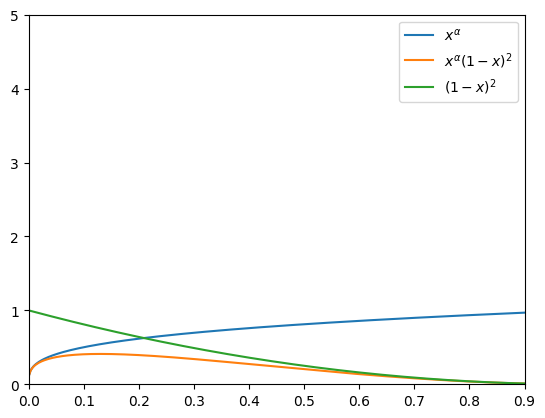

In [8]:
x = np.linspace(0.001, 0.999, 400)

alpha = 0.3

# Plot the function x^(-alpha)
plt.plot(x, x**(alpha), label=r"$x^{\alpha}$")
plt.plot(x, x**(alpha)*(1-x)**2, label=r"$x^{\alpha}(1-x)^2$")
plt.plot(x, (1-x)**2, label=r"$(1-x)^2$")
plt.ylim(0, 5)
plt.xlim(0, 0.9)
plt.legend()
plt.show()


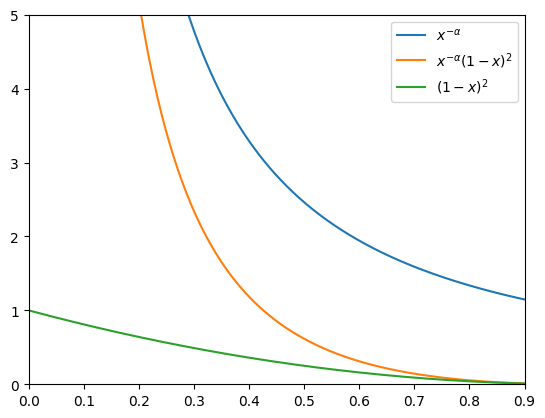

In [9]:
x = np.linspace(0.001, 0.999, 400)

alpha = 1.3

# Plot the function x^(-alpha)
plt.plot(x, x**(-alpha), label=r"$x^{-\alpha}$")
plt.plot(x, x**(-alpha)*(1-x)**2, label=r"$x^{-\alpha}(1-x)^2$")
plt.plot(x, (1-x)**2, label=r"$(1-x)^2$")
plt.ylim(0, 5)
plt.xlim(0, 0.9)
plt.legend()
plt.show()

### PV17 fNP for PDF

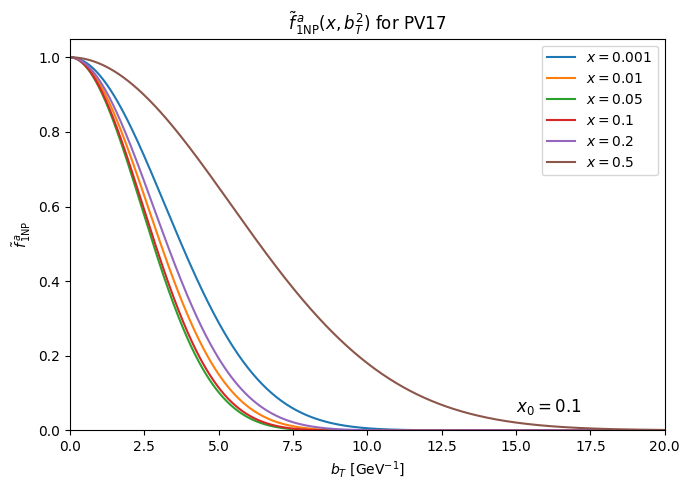

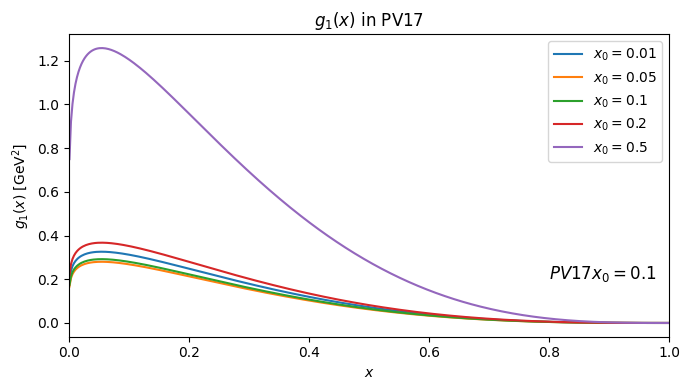

In [10]:
# PV17 fNP for PDF
import numpy as np
import matplotlib.pyplot as plt

# --- Central values from  PV17 paper
N1     = 0.28   # GeV^2  (this is the "g1" scale parameter in the table)
alpha  = 2.95   # dimensionless
sigma  = 0.17   # dimensionless
lam    = 0.86   # GeV^-2

# --- Pivot point \hat{x} used in the definition of g1(x)
xhat = .1

def g1_of_x(x, N1=N1, alpha=alpha, sigma=sigma, xhat=xhat):
    """
    g1(x) = N1 * ( (1-x)^alpha * x^sigma ) / ( (1-xhat)^alpha * xhat^sigma )
    Valid for 0 < x < 1.
    """
    x = np.asarray(x, dtype=float)
    num = (1.0 - x)**alpha * x**sigma
    den = (1.0 - xhat)**alpha * (xhat**sigma)
    return N1 * num / den  # GeV^2

def f1NP_bspace(x, bT, N1=N1, alpha=alpha, sigma=sigma, lam=lam, xhat=xhat):
    """
    \tilde f_{1NP}^a(x,b_T^2) =
      (1/2π) exp[- g1(x) b_T^2 / 4] * ( 1 - [λ g1(x)^2 / (1 + λ g1(x))] * (b_T^2/4) )
    bT in GeV^-1.
    
    The factor (1/2π) is the Fourier transform factor. Without it, the function 
    is normalized to 1 at bT=0.
    """
    x  = np.asarray(x, dtype=float)
    bT = np.asarray(bT, dtype=float)

    g  = g1_of_x(x, N1=N1, alpha=alpha, sigma=sigma, xhat=xhat)  # GeV^2
    t  = (bT**2) / 4.0   # GeV^-2
    fourier_transform_factor = (1.0/(2.0*np.pi))

    return np.exp(-g * t) * (1.0 - (lam * g**2 / (1.0 + lam * g)) * t)
    # return (1.0/(2.0*np.pi)) * np.exp(-g * t) * (1.0 - (lam * g**2 / (1.0 + lam * g)) * t)


# --- Plot vs bT for several x values
bT = np.linspace(0.0, 20.0, 500)  # GeV^-1
x_list = [0.001, 0.01, 0.05,  0.10, 0.20, 0.50]

plt.figure(figsize=(7,5))
for x in x_list:
    plt.plot(bT, f1NP_bspace(x, bT), label=fr"$x={x}$")

plt.title(r"$\tilde f_{1\mathrm{NP}}^{\,a}(x,b_T^2)$ for PV17")
plt.xlabel(r"$b_T\ [\mathrm{GeV}^{-1}]$")
plt.ylabel(r"$\tilde f_{1\mathrm{NP}}^{\,a}$")
plt.text(15, 0.05, fr"$x_0={xhat}$", fontsize=12)
plt.ylim(bottom=0)
plt.xlim(0, 20)
plt.legend()
plt.tight_layout()
plt.savefig(plots_dir / f"f1NP_bspace_PV17_x0_{xhat}.pdf")
plt.show()


# Define xgrid
xhat_list = [0.01, 0.05, 0.1, 0.2, 0.5]
xgrid = np.linspace(0.001, 0.999, 400)

# Also plot g1(x) itself to sanity-check the x-shape.
# Plot g1(x) for different x0 values
plt.figure(figsize=(7,4))
for xhat in xhat_list:
    plt.plot(xgrid, g1_of_x(xgrid, xhat=xhat), label=fr"$x_0={xhat}$")
plt.title(r"$g_1(x)$ in PV17")
plt.xlim(0, 1)
plt.xlabel(r"$x$")
plt.ylabel(r"$g_1(x)\ [\mathrm{GeV}^2]$")
plt.text(0.8, 0.2, fr"$PV17 x_0=0.1$", fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig(plots_dir / f"g1_of_x_PV17_x0.pdf")
plt.show()


## Section 3: Check: Model Initialization with Base Flexible Config

In [13]:
# Initialize the trainable model with flexible config
rootdir = pathlib.Path().resolve().parent

# fnp_config = "fNPconfig_base_flexible.yaml"
fnp_config = "fNPconfig_simple.yaml"

print(f"{tcolors.BOLDWHITE}Initializing model with config: {fnp_config}{tcolors.ENDC}")
model = TrainableModel(fnp_config=fnp_config)

print(f"{tcolors.GREEN}Model initialized successfully!{tcolors.ENDC}")
print(f"Model is in training mode: {model.training}")

Initializing model with config: fNPconfig_simple.yaml

[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_u_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_d_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_s_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_c_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_cb_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_sb_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/sidis/model/../../grids/grids/tmdpdf_db_Q_1.28.txt


[OPE] Initializing OPE
  Grid file: /Users/cbissolotti/anl/projects/tmd/si

## Section 4: Generate Cross Sections

Load kinematic events from a mock data file, run the flexible model to compute cross sections, and optionally save outputs. Choose the events file path below (default: `mock_events.dat` from the same directory).

In [14]:
# Output folder path
outs_dir = pathlib.Path().resolve() / "outs"
outs_dir.mkdir(parents=True, exist_ok=True)

In [15]:
# Generate cross sections from a chosen mock data file
events_file_path = pathlib.Path().resolve() / "mock_events.dat"  # change to use a different file
events_file_path = pathlib.Path().resolve() / "mock_events_1000.dat"  # change to use a different file

if not events_file_path.exists():
    raise FileNotFoundError(f"{tcolors.RED}Events file not found: {events_file_path}\nRun the mock data cell above first.{tcolors.ENDC} ")

# Torch load the events from the mock data file (.dat)
# and get number of events
events_tensor = torch.load(events_file_path)
n_events = events_tensor.shape[0]

print(f"{tcolors.BOLDWHITE}Loading model and computing cross sections...{tcolors.ENDC}")
print(f"  Events file: {events_file_path}")
print(f"  Shape: {events_tensor.shape} (x, PhT, Q, z)")

# Load trainable model and evaluate. Each parameter is initialized with an init_val 
# taken directly from the init_params in the yaml.
# model = TrainableModel(fnp_config="fNPconfig_base_flexible.yaml")
model = TrainableModel(fnp_config="fNPconfig_simple.yaml")
model.eval()

# Disables gradient tracking inside the block. 
# No computation graph is built and no gradients are stored. 
# This reduces memory and speeds up inference, since gradients are not 
# needed for prediction.
with torch.no_grad():
    # Run the model forward pass. The model takes the events tensor and 
    # returns the cross section, with a shape of (n_events,), one value per event.
    cross_section = model(events_tensor)

# Ensure the cross section and events are on the CPU.
cross_section = cross_section.cpu()
events_cpu = events_tensor.cpu()

# Save to outs/ (same format as run_cross_section_from_mock.py)
torch.save({"events": events_cpu, "cross_section": cross_section}, outs_dir / "cross_section_output.pt")
print(f"{tcolors.GREEN}Saved to {plots_dir / 'cross_section_output.pt'}{tcolors.ENDC}")

print(f"\n{tcolors.BOLD}Cross-section range: [{cross_section.min().item():.4e}, {cross_section.max().item():.4e}]{tcolors.ENDC}")

AttributeError: type object 'tcolors' has no attribute 'RED'

### Plot cross sections

In [ ]:
# Plot generated cross sections. Kinematic comes from the events 
x_ev = events_cpu[:, 0].numpy()
PhT_ev = events_cpu[:, 1].numpy()
Q_ev = events_cpu[:, 2].numpy()
z_ev = events_cpu[:, 3].numpy()

xsec = cross_section.numpy()

# Check for negative values and print cross sections that have a negative value
negative_xsec = xsec[xsec < 0]
print(f"{tcolors.FAIL}Number of negative cross sections: {len(negative_xsec)}{tcolors.ENDC}")
print(f"{tcolors.GREEN}Total number of cross sections: {len(xsec)}{tcolors.ENDC}\n")
# Uncomment to print the minimum and maximum cross sections
# print(f"{tcolors.FAIL}Maximum negative cross section: {negative_xsec.min()}{tcolors.ENDC}")
# print(f"{tcolors.FAIL}Minimum cross section         : {cross_section.min().item()}{tcolors.ENDC}")
# print(f"{tcolors.FAIL}Minimum negative cross section: {negative_xsec.max()}{tcolors.ENDC}")


# Use log scale for cross-section (often spans many orders of magnitude)
xsec_plot = np.abs(xsec)
xsec_plot = np.where(xsec_plot > 0, xsec_plot, 1e-30)  # avoid log(0)

# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(11, 9), facecolor="white")

# Histogram of cross-section (log scale)
axes[0, 0].hist(np.log10(xsec_plot), bins=35, color="#0173b2", edgecolor="white", linewidth=0.8, alpha=0.85)
axes[0, 0].set_xlabel(r"$\log_{10}$(|cross-section|)", fontsize=11)
axes[0, 0].set_ylabel("Counts", fontsize=11)
axes[0, 0].set_title("Cross-section distribution", fontsize=12, fontweight="bold")
axes[0, 0].grid(True, alpha=0.25, linestyle="--")
axes[0, 0].set_axisbelow(True)

# x vs Q colored by cross-section
sc = axes[0, 1].scatter(x_ev, Q_ev, c=np.log10(xsec_plot), cmap="viridis", s=25, alpha=0.8, edgecolors="white", linewidths=0.3)
axes[0, 1].set_xlabel("x (Bjorken x)", fontsize=11)
axes[0, 1].set_ylabel("Q (GeV)", fontsize=11)
axes[0, 1].set_title("x vs Q (color = log₁₀|cross-section|)", fontsize=12, fontweight="bold")
axes[0, 1].set_xscale("log")
axes[0, 1].set_yscale("log")
axes[0, 1].grid(True, alpha=0.25, linestyle="--")
plt.colorbar(sc, ax=axes[0, 1], label=r"$\log_{10}$(|σ|)")
axes[0, 1].set_axisbelow(True)

# z vs cross-section (scatter)
axes[1, 0].scatter(z_ev, xsec, s=20, c="#029e73", alpha=0.7, edgecolors="white", linewidths=0.3)
axes[1, 0].set_xlabel("z", fontsize=11)
axes[1, 0].set_ylabel("Cross-section", fontsize=11)
axes[1, 0].set_title("Cross-section vs z", fontsize=12, fontweight="bold")
axes[1, 0].set_yscale("symlog", linthresh=1e-15)
axes[1, 0].grid(True, alpha=0.25, linestyle="--")
axes[1, 0].set_axisbelow(True)

# PhT vs cross-section (scatter)
axes[1, 1].scatter(PhT_ev, xsec, s=20, c="#cc78bc", alpha=0.7, edgecolors="white", linewidths=0.3)
axes[1, 1].set_xlabel(r"$P_{hT}$ (GeV)", fontsize=11)
axes[1, 1].set_ylabel("Cross-section", fontsize=11)
axes[1, 1].set_title(r"Cross-section vs $P_{hT}$", fontsize=12, fontweight="bold")
axes[1, 1].set_yscale("symlog", linthresh=1e-15)
axes[1, 1].grid(True, alpha=0.25, linestyle="--")
axes[1, 1].set_axisbelow(True)

fig.suptitle(f"Cross sections from {events_file_path.name} (n = {n_events})", fontsize=14, fontweight="bold", y=1.02)
plt.savefig(plots_dir / f"cross_sections_from_{events_file_path.name}.pdf")
plt.tight_layout()
plt.show()

### investigate negative cross sections if necessary

In [ ]:
# Print the events that have a negative cross section
negative_events = events_cpu[xsec < 0]
print(f"{tcolors.BOLD}{tcolors.FAIL}Events with negative cross section:{tcolors.ENDC}\n")
print(f"{tcolors.BOLD}x: {negative_events[:, 0].numpy()}\n")
print(f"{tcolors.BOLD}PhT: {negative_events[:, 1].numpy()}\n")
print(f"{tcolors.BOLD}Q: {negative_events[:, 2].numpy()}\n")
print(f"{tcolors.BOLD}z: {negative_events[:, 3].numpy()}\n")

print(f"{tcolors.FAIL}Events with negative cross section, in order:{tcolors.ENDC}\n")
print(negative_events)

# Print the cross section values for the negative events
print(f"{tcolors.BOLD}{tcolors.FAIL}\nCross section values for negative events:{tcolors.ENDC}")
print(xsec[xsec < 0])